# Sentiment_Analysis_Challenge using TensorFlow

Application of Recurrent Neural Network

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
# tensorflow
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pickle
df = pd.read_pickle('ign_dataset.pkl')
df.shape



(18622, 2)

In [5]:
df.head()

,sentiment,text
0,Positive,LittleBigPlanet PS Vita PlayStation Vita Platf...
1,Positive,LittleBigPlanet PS Vita -- Marvel Super Hero E...
2,Positive,Splice: Tree of Life iPad Puzzle N
3,Positive,NHL 13 Xbox 360 Sports N
4,Positive,NHL 13 PlayStation 3 Sports N


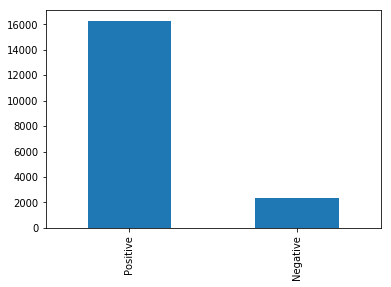

In [6]:
df.sentiment.value_counts().plot(kind='bar')

In [7]:
df.sentiment.value_counts(normalize=True)

Positive    0.874074
Negative    0.125926
Name: sentiment, dtype: float64

In [0]:
X = df.text
y = df.sentiment

In [9]:
print(X.shape)
print(y.shape)

(18622,)
(18622,)


### Train-Test-Split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2019)

### Create the vocab 

(so that we can create X_word_ids from X)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(1,1), token_pattern=r'\b\w{1,}\b')

In [0]:
vect.fit(X_train)
vocab = vect.vocabulary_

In [0]:
def convert_X_to_X_word_ids(X):
    return X.apply( lambda x: [vocab[w] for w in [w.lower().strip() for w in x.split()] if w in vocab] )

In [0]:
X_train_word_ids = convert_X_to_X_word_ids(X_train)
X_test_word_ids  = convert_X_to_X_word_ids(X_test)

### Difference between X(_train/_test) and X(_train_word_ids/test_word_ids)

In [15]:
X_train.head()

836                NFL Xtreme PlayStation Sports, Action N
11378    Madden NFL 09 (20th Anniversary Collector's Ed...
7638     World Soccer Winning Eleven 9 PlayStation Port...
812                Bio F.R.E.A.K.S. PlayStation Fighting N
18068                               I Am Bread PC Puzzle N
Name: text, dtype: object

In [16]:
X_train_word_ids.head()

836                          [4582, 7492, 5072, 245, 4486]
11378         [4030, 4582, 12, 445, 5072, 147, 6263, 7498]
7638     [7427, 6137, 7374, 2283, 196, 5072, 5118, 6263...
812                                [856, 5072, 2574, 4486]
18068                  [3372, 382, 1047, 4928, 5259, 4486]
Name: text, dtype: object

In [17]:
print('X_train_word_ids.shape:', X_train_word_ids.shape)
print('X_test_word_ids.shape:', X_test_word_ids.shape)

X_train_word_ids.shape: (16759,)
X_test_word_ids.shape: (1863,)


In [18]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (16759,)
X_test shape: (1863,)


In [19]:
print(len(X_train))
print(len(X_test))

16759
1863


**Shape is same.**

### Sequence Padding

In [0]:
X_train_padded_seqs = pad_sequences(X_train_word_ids, maxlen=20, value=0)
X_test_padded_seqs  = pad_sequences(X_test_word_ids , maxlen=20, value=0)

In [21]:
print('X_train_padded_seqs.shape:', X_train_padded_seqs.shape)
print('X_test_padded_seqs.shape:', X_test_padded_seqs.shape)

X_train_padded_seqs.shape: (16759, 20)
X_test_padded_seqs.shape: (1863, 20)


In [0]:
# X_train_padded_seqs.head()

#AttributeError: 'numpy.ndarray' object has no attribute 'head'

**We can create dataframe to see this array**

In [23]:
pd.DataFrame(X_train_padded_seqs).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4582,7492,5072,245,4486
1,0,0,0,0,0,0,0,0,0,0,0,0,4030,4582,12,445,5072,147,6263,7498
2,0,0,0,0,0,0,0,0,0,0,0,7427,6137,7374,2283,196,5072,5118,6263,4486
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,856,5072,2574,4486
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3372,382,1047,4928,5259,4486


In [24]:
pd.DataFrame(X_test_padded_seqs).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,4260,487,4792,7462,153,1537,4486
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6983,4230,158,5072,245,4486
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3337,2813,245,4486
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5614,4769,5072,75,263,4486
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4619,2161,7190,4960,4486


### working with y(label) variable

Convert (y) labels to vectors like we did with X

In [25]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

['Positive', 'Negative']

In [26]:
len(unique_y_labels)

2

In [27]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(unique_y_labels)

LabelEncoder()

In [28]:
print('')
for label_id, label_name in zip(le.transform(unique_y_labels), unique_y_labels):
    print('%d: %s' % (label_id, label_name))
print('')


1: Positive
0: Negative



In [29]:
print(y_train.shape)
print(y_test.shape)

(16759,)
(1863,)


In [0]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

In [31]:
y_train[:5]

836      Positive
11378    Positive
7638     Positive
812      Positive
18068    Positive
Name: sentiment, dtype: object

In [32]:
y_train_ohe[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [33]:
y_test[:5]

229      Positive
1718     Positive
4831     Positive
5233     Positive
10961    Negative
Name: sentiment, dtype: object

In [34]:
y_test_ohe[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

**We can always find solution of a problem. Converting into dataframe thanks to pandas**

In [35]:
y_train.head()

836      Positive
11378    Positive
7638     Positive
812      Positive
18068    Positive
Name: sentiment, dtype: object

In [0]:
# y_train_ohe.head()......convert to dataframe

In [37]:
pd.DataFrame(y_train_ohe).head()

,0,1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [38]:
pd.DataFrame(y_test_ohe).head()

,0,1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


# Model

### a)-Network Building

In [0]:
size_of_each_vector = X_train_padded_seqs.shape[1]
vocab_size = len(vocab)
no_of_unique_y_labels = len(unique_y_labels)

In [40]:

print('size_of_each_vector:', size_of_each_vector)
print('vocab_size:', vocab_size)
print('no_of_unique_y_labels:', no_of_unique_y_labels)

size_of_each_vector: 20
vocab_size: 7598
no_of_unique_y_labels: 2


In [41]:
net = tflearn.input_data([None, size_of_each_vector]) # The first element is the "batch size" which we set to "None"
net = tflearn.embedding(net, input_dim=vocab_size, output_dim=128) # input_dim: vocabulary size
net = tflearn.lstm(net, 128, dropout=0.6) # Set the dropout to 0.6
net = tflearn.fully_connected(net, no_of_unique_y_labels, activation='softmax') # relu or softmax
net = tflearn.regression(net, 
                         optimizer='adam',  # adam or ada or adagrad # sgd
                         learning_rate=1e-4,
                         loss='categorical_crossentropy')

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### b) Intialize the Model

In [42]:
model = tflearn.DNN(net, tensorboard_verbose=0)

Instructions for updating:
Use tf.cast instead.


### c)- Train model

In [43]:
history=model.fit(X_train_padded_seqs, y_train_ohe, 
           validation_set=(X_test_padded_seqs, y_test_ohe), 
           n_epoch=10,
           show_metric=True, 
           batch_size=100)

Training Step: 1679  | total loss: 0.22221 | time: 3.809s
| Adam | epoch: 010 | loss: 0.22221 - acc: 0.8991 -- iter: 16700/16759
Training Step: 1680  | total loss: 0.22279 | time: 4.835s
| Adam | epoch: 010 | loss: 0.22279 - acc: 0.8981 | val_loss: 0.33463 - val_acc: 0.8755 -- iter: 16759/16759
--


# Evaluate model

In [0]:
y_pred = model.predict(X_test_padded_seqs)

In [45]:
y_pred[:5]

array([[0.00145658, 0.9985435 ],
       [0.05442747, 0.94557256],
       [0.21875852, 0.7812415 ],
       [0.4053382 , 0.5946618 ],
       [0.37710702, 0.622893  ]], dtype=float32)

**These are probabilities of output i.e for 0 and 1**

In [46]:
y_test_ohe[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [0]:
## predict crisp classes for test set. Output will be 1-D
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

**Converting prob. into crisp classes i.e in 1D.**

In [48]:
y_pred_class[:5]

array([1, 1, 1, 1, 1])

In [49]:
y_test_class[:5]

array([1, 1, 1, 1, 0])

# Accuracy

In [0]:
import numpy as np
from sklearn import metrics

In [0]:
#pred_classes = [np.argmax(i) for i in model.predict(X_test_padded_seqs)]
#true_classes = [np.argmax(i) for i in y_test_ohe]

In [52]:
print('\nText Classifier\'s Accuracy: %0.5f\n' % metrics.accuracy_score(y_test_class,y_pred_class))


Text Classifier's Accuracy: 0.87547



### Classification Report

In [53]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.48      0.14      0.22       229
           1       0.89      0.98      0.93      1634

    accuracy                           0.88      1863
   macro avg       0.68      0.56      0.58      1863
weighted avg       0.84      0.88      0.84      1863



### Confusion Matrix

In [54]:
print(confusion_matrix(y_test_class,y_pred_class))

[[  33  196]
 [  36 1598]]
